In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.utils
import torchvision
import torchvision.io

import _frameload

totensor = _frameload.totensor
topilimage = _frameload.topilimage
transform_forward = _frameload.transform_forward
transform_backward = _frameload.transform_backward

batch_size = 1024


In [2]:
# get Files object so we can keep track of what's used, etc...
files = _frameload.FrameFiles()


In [3]:
# get training dataset, but DO NOT get testing dataset: too little memory for both
dataset_train = _frameload.Frame(files, 'train')


img     1488	 shape torch.Size([3, 384, 384]) 	 type photo
img     2403	 shape torch.Size([3, 384, 384]) 	 type photo
img     1943	 shape torch.Size([3, 384, 384]) 	 type anime
img     1495	 shape torch.Size([3, 384, 384]) 	 type anime


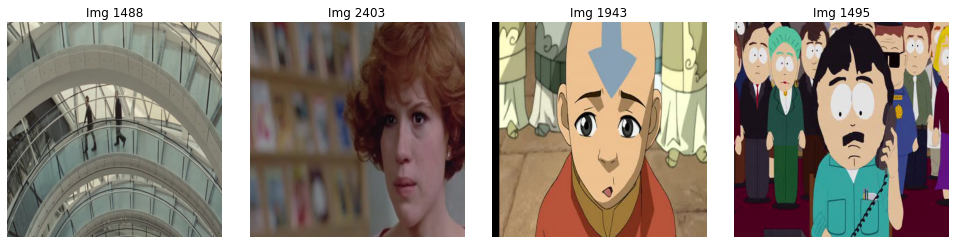

img     1923	 shape torch.Size([3, 384, 384]) 	 type anime
img     3376	 shape torch.Size([3, 384, 384]) 	 type anime
img     2152	 shape torch.Size([3, 384, 384]) 	 type anime
img     3082	 shape torch.Size([3, 384, 384]) 	 type photo


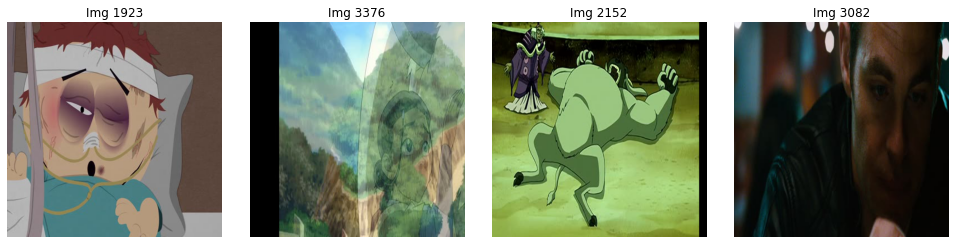

img     3064	 shape torch.Size([3, 384, 384]) 	 type photo
img      998	 shape torch.Size([3, 384, 384]) 	 type photo
img      854	 shape torch.Size([3, 384, 384]) 	 type anime
img     2303	 shape torch.Size([3, 384, 384]) 	 type photo


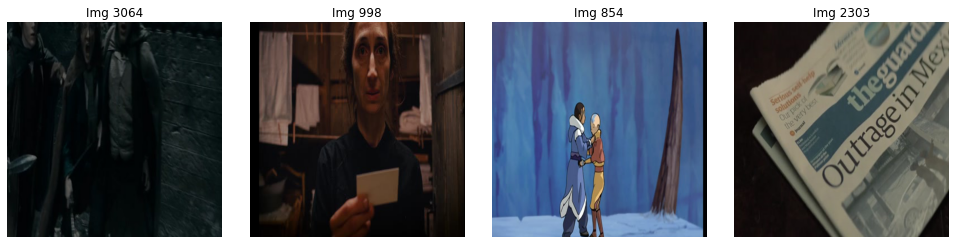

img      583	 shape torch.Size([3, 384, 384]) 	 type photo
img     2854	 shape torch.Size([3, 384, 384]) 	 type photo
img     3899	 shape torch.Size([3, 384, 384]) 	 type anime
img      323	 shape torch.Size([3, 384, 384]) 	 type anime


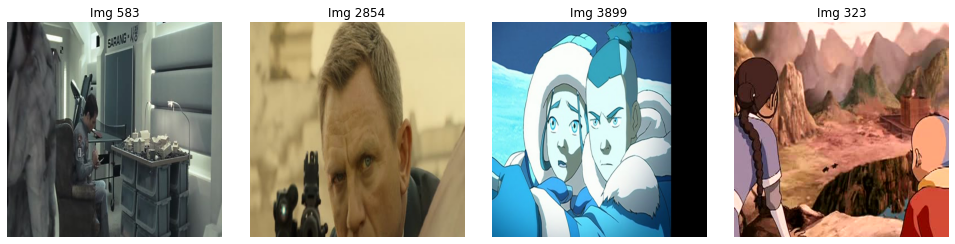

In [4]:
n_subplots = 4
figwidth = 14

def showRandom(d):
    fig, axes = plt.subplots(1, n_subplots, figsize=(figwidth, figwidth / n_subplots))
    for i, imgidx in enumerate(np.random.randint(0, len(d), n_subplots)):
        image, label = d[imgidx]
        print(f'img {imgidx:8d}\t', f'shape {str(image.shape):26s}\t',
              'type', 'anime' if label == 1 else 'photo')

        ax = axes[i]
        ax.imshow(transform_backward(image))
        ax.set_title(f'Img {imgidx}')
        ax.axis('off')

        plt.tight_layout()

    plt.show()


for _ in range(4):
    showRandom(dataset_train)


In [5]:
print(f'Training N photo:\t{np.sum(dataset_train.labels.numpy() == 0):8d}')
print(f'Training N anime:\t{np.sum(dataset_train.labels.numpy() == 1):8d}')
print(f'Training N:\t\t{len(dataset_train):8d}')


Training N photo:	    2000
Training N anime:	    2000
Training N:		    4000


In [6]:
# refresh data underlying dataset_train
dataset_train.refresh()


img      968	 shape torch.Size([3, 384, 384]) 	 type photo
img      292	 shape torch.Size([3, 384, 384]) 	 type photo
img     1233	 shape torch.Size([3, 384, 384]) 	 type anime
img     2529	 shape torch.Size([3, 384, 384]) 	 type anime


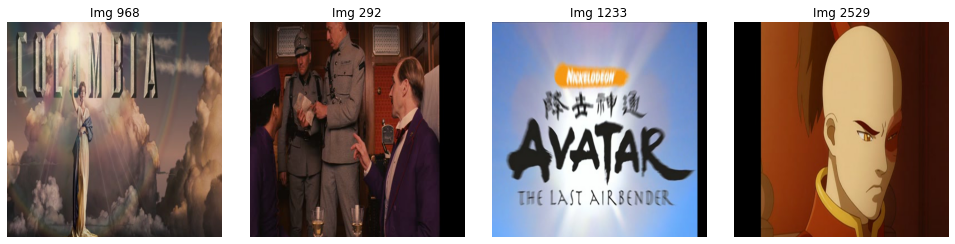

img      713	 shape torch.Size([3, 384, 384]) 	 type photo
img      405	 shape torch.Size([3, 384, 384]) 	 type anime
img     1345	 shape torch.Size([3, 384, 384]) 	 type anime
img     2949	 shape torch.Size([3, 384, 384]) 	 type anime


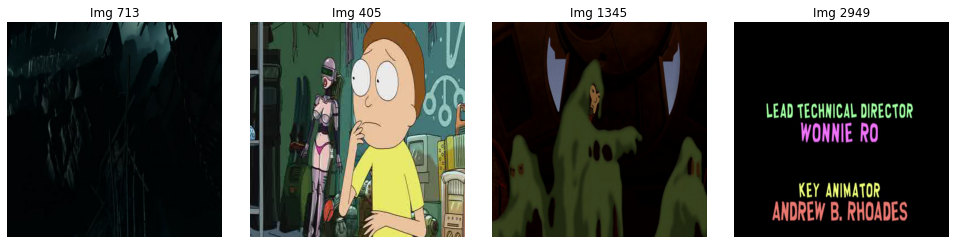

img     2706	 shape torch.Size([3, 384, 384]) 	 type photo
img     2270	 shape torch.Size([3, 384, 384]) 	 type photo
img     2013	 shape torch.Size([3, 384, 384]) 	 type anime
img     1897	 shape torch.Size([3, 384, 384]) 	 type anime


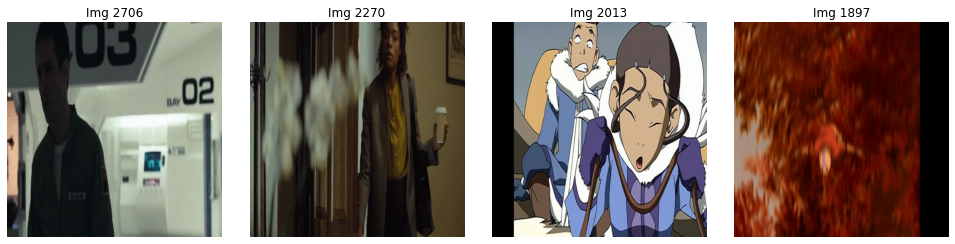

img     1964	 shape torch.Size([3, 384, 384]) 	 type anime
img     3177	 shape torch.Size([3, 384, 384]) 	 type anime
img      750	 shape torch.Size([3, 384, 384]) 	 type photo
img     1951	 shape torch.Size([3, 384, 384]) 	 type photo


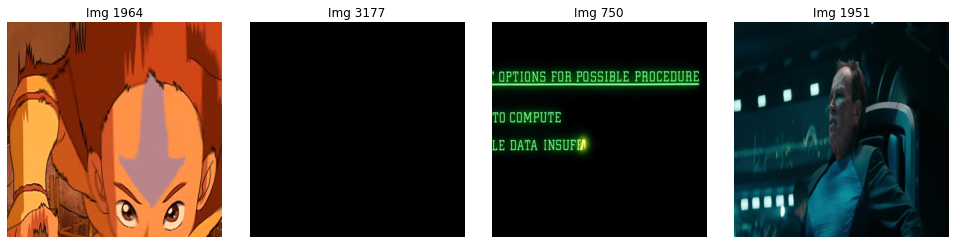

In [7]:
for _ in range(4):
    showRandom(dataset_train)


In [8]:
print(f'Training N photo: {np.sum(dataset_train.labels.numpy() == 0):8d}')
print(f'Training N anime: {np.sum(dataset_train.labels.numpy() == 1):8d}')


Training N photo:    30000
Training N anime:    30000


In [7]:
class IsAnime(torch.nn.Module):
    def __init__(self):
        super(IsAnime, self).__init__()

        self.epoch = 0

        self.kernel = 9

        self.conv1 = torch.nn.Conv2d(3, 6, self.kernel)
        self.conv2 = torch.nn.Conv2d(6, 16, self.kernel)
        self.fc1 = torch.nn.Linear(1600, 1024)
        self.fc2 = torch.nn.Linear(1024, 256)
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc4 = torch.nn.Linear(64, 1)
        
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.pool = torch.nn.MaxPool2d(2)
        self.sigmoidsharp = lambda x: torch.nn.ReLU6()(x * 6) / 6

    def forward(self, x):
        
        x.float()
        
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = torch.squeeze(x)

        x.float()
        
        return self.sigmoidsharp(x)


import torch.nn as nn
import torch.nn.functional as F
class IsAnimeAlternate(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 12, 5)
        self.fc1 = nn.Linear(2028, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

        self.epoch = 0

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.squeeze(F.relu6(x * 6) / 6)


class ReallySimpleClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.epoch = 0
        self.lr = 1e-4

        self.activation = torch.nn.Sigmoid()
        self.pool = torch.nn.MaxPool2d(2)

        self.conv1 = torch.nn.Conv2d(3, 9, 5)
        self.fc1 = torch.nn.Linear(8100, 1)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = torch.squeeze(x)
        return x


net = ReallySimpleClassifier().cuda()
net.float()  # to be extra sure

print(net)


ReallySimpleClassifier(
  (activation): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=8100, out_features=1, bias=True)
)


In [8]:
import torchsummary
torchsummary.summary(net, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 60, 60]             684
           Sigmoid-2            [-1, 9, 60, 60]               0
         MaxPool2d-3            [-1, 9, 30, 30]               0
            Linear-4                    [-1, 1]           8,101
           Sigmoid-5                    [-1, 1]               0
Total params: 8,785
Trainable params: 8,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.56
Params size (MB): 0.03
Estimated Total Size (MB): 0.64
----------------------------------------------------------------


In [9]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=net.lr, momentum=0.9)


In [10]:
batch_size = int(1024)

# technically I already shuffled, but it probably doesn't matter, right?
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [11]:
print('Training...')

epsilon_train = 0.0001  # smaller than <epsilon_train> change in ratios of loss values

loss_last = 1000000000.
loss_this = 100000000.  # some number bigger than any possible loss
while loss_last / loss_this > 1 + epsilon_train:
    loss_last = loss_this
    loss_this = 0.
    net.epoch += 1

    for i, data in enumerate(loader_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].cuda(), data[1].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()            
        optimizer.step()

        # print statistics
        loss_this += loss.item()
        # print(f'\tBatch {i:02d} loss: {loss.item():.2f}')
    print(f'Epoch {net.epoch:02d} loss: {loss_this:.3f}')


print('Finished training.')


Training...
Epoch 01 loss: 40.065
Epoch 02 loss: 37.534
Epoch 03 loss: 35.159
Epoch 04 loss: 33.011
Epoch 05 loss: 31.505
Epoch 06 loss: 30.660
Epoch 07 loss: 30.256
Epoch 08 loss: 30.000
Epoch 09 loss: 29.866
Epoch 10 loss: 29.834
Epoch 11 loss: 29.745
Epoch 12 loss: 29.662
Epoch 13 loss: 29.624
Epoch 14 loss: 29.630
Finished training.


In [12]:
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(loader_test):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = net(images)
        predictions = [1. if f >= 0.5 else 0. for f in outputs]
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct += 1
            total += 1
            
        if i > 10:
            break


# print accuracy for each class
print('correct', correct)
print('total', total)


correct 9582
total 12288


In [13]:
print(f'{correct / total * 100:03.1f}%')


77.9%


In [14]:
torch.save(net.state_dict(), os.path.join('model', f'{net._get_name()}_{datetime.datetime.now().strftime("%Y%m%dT%H%M")}.pth'))
